# Local registration with ICP

In the RGBD folder we have the first 400 images from one of the datasets from: [http://redwood-data.org/indoor_lidar_rgbd/download.html](http://redwood-data.org/indoor_lidar_rgbd/download.html)

In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy
        
# Helper function to draw registrations (reccomended)
def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Creating point clouds from image data
Now we are going to try to create our own point clouds from RGB+depth images.
First, we load two RGBD images.

In [2]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")

color_raw1 = o3d.io.read_image("RGBD/color/000300.jpg")
depth_raw1 = o3d.io.read_image("RGBD/depth/000300.png")

Create point clouds from rgb + depth images.

If you set `convert_rgb_to_intensity = False` you will retain the colors from the rgb image.

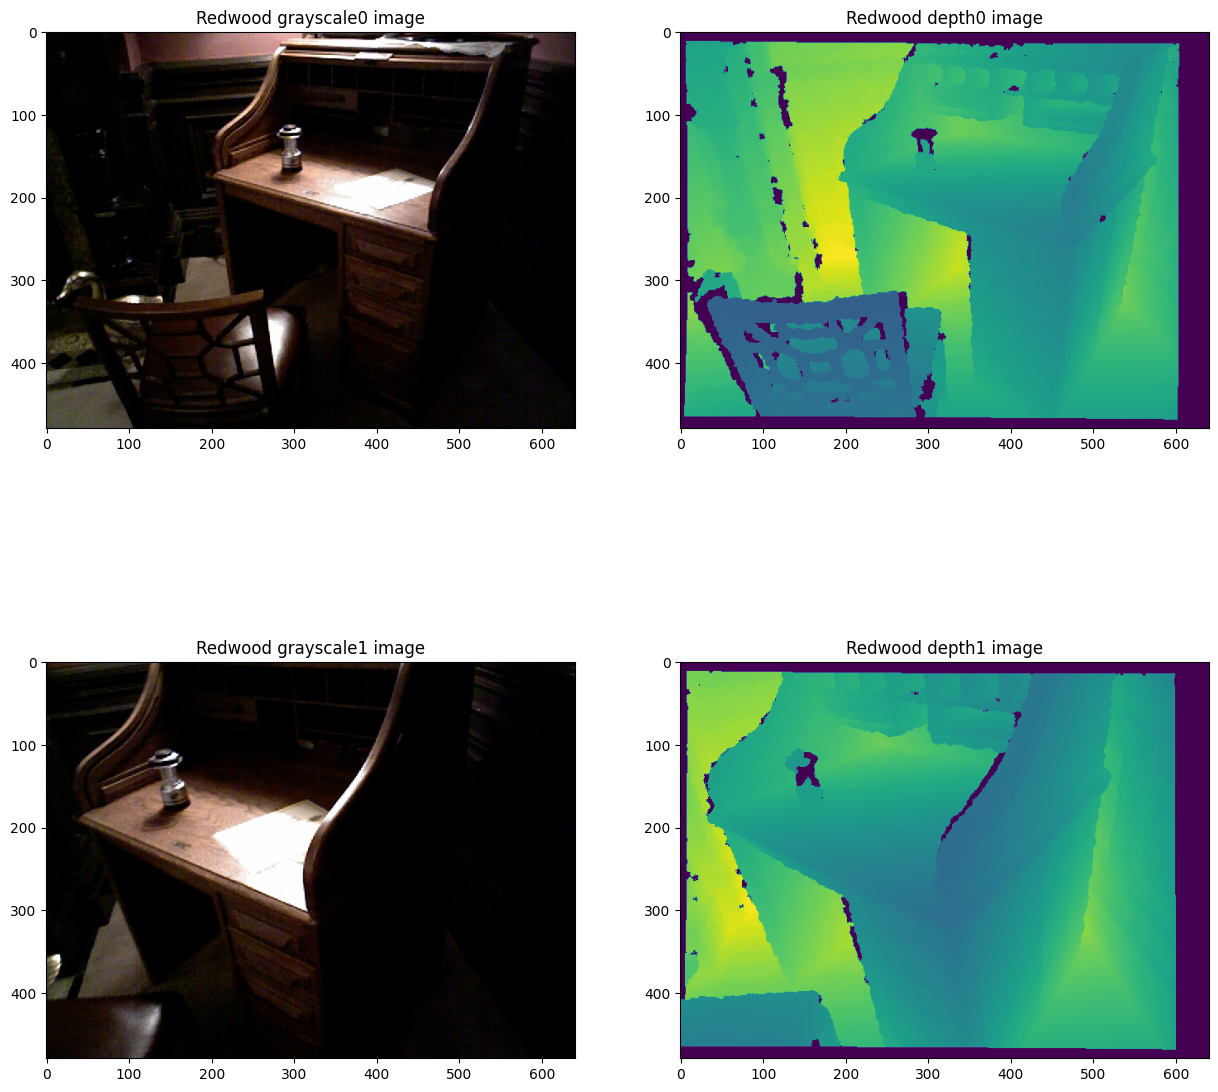

In [3]:
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = False)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = False)

#show images
fig= plt.figure(figsize=(15,15))
# plt.gray()
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()


## Images to point cloud
Now we create point clouds from the RGBD images we just loaded/created.


Here, we use `PinholeCameraIntrinsicParameters.PrimeSenseDefault` as default camera parameters. 

It has an image resolution of 640x480, focal length of ($f_x$, $f_y$) = (525.0, 525.0), and optical center ($c_x$, $c_y$) = (319.5, 239.5). 

An identity matrix is used as default extrinsic parameters. `pcd.transform` applies an up-down flip transformation on the point cloud for an improved visualization.


If execution becomes too slow you can downsample the point cloud.

In [4]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)


### Evaluation of pointclouds

Before we can run ICP, we evaluate our source and target point clouds. This gives us a feeling if we need a better initial transformation or not.
From (http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html):

"The function `evaluate_registration` calculates two main metrics. 
- `fitness` measures the overlapping area (# of inlier correspondences / # of points in target). The higher the better. 
- `inlier_rmse` measures the RMSE of all inlier correspondences. The lower the better.

In [5]:
# Parameters
threshold = 0.2
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=5.879230e-01, inlier_rmse=1.178853e-01, and correspondence_set size of 153803
Access transformation to get result.


## ICP

Now try to call icp with your point clouds and your initial transformation.

Initially we use:
```Python
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

In [6]:
###
# ICP code here
###
source.estimate_normals()
target.estimate_normals()
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
#icp_result = o3d.pipelines.registration.registration_icp()

draw_registrations(source, target, icp_result.transformation, True)
# draw_registrations(source, target, icp_result.transformation)

# Exersices

### A)
If you increase the amount of steps from the original image so from i.e. 000000.jpg<>000005.jpg to 00000.jpg<>000300.jpg, what happens?
The result is pretty bar :(
### B)
Can you tweak the parameters `threshold` and `trans_init` to combat some of the ill effects that starts appearing?
Ok, increasing the threshold from 0.02 to 0.2 helped a lot
### C)
Again try to use 
```Python
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

This requires you to find the normals for each point cloud use:
```python
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
```
Compare the resulting translations of the two methods. Is one better than the other?
### D)
Extend this and try to see how much of the bedroom you can reconstruct from the RGB and depth images.
You can extend a point cloud by `new = source + target`. Remember to resample the point cloud after a view additions so it does not get too large: `down_source = source.voxel_down_sample(voxel_size=0.05)`

In [7]:
source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                        max_nn=30),fast_normal_computation=True)
target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                        max_nn=30),fast_normal_computation=True)

point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)



In [8]:

draw_registrations(source, target, reg_p2p.transformation, True)